# Imports and auxiliary functions for plotting

In [1]:
import pandas as pd
import numpy as np
import io
import re

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import seaborn as sns; sns.set(); sns.set(font_scale=1.0); sns.set_style("white"); 

import matplotlib as mpl
from matplotlib import pyplot as plt
#%matplotlib inline

def _reset_mpl_config(font_size = 17*1.5, cmbright=True):
    mpl.rcParams.update(mpl.rcParamsDefault) #reset to defaults
        
    SMALL_SIZE = font_size-4
    MEDIUM_SIZE = font_size
    BIGGER_SIZE = font_size
    
    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

    plt.rc('font',**{'family':'serif','serif':['Times'], "weight": "normal"})
    plt.rc('text', usetex=True)
    plt.rc('mathtext', fontset='stix')  #['dejavusans', 'dejavuserif', 'cm', 'stix', 'stixsans', 'custom']
    
    mpl.rcParams['text.latex.preamble'] = [
            r'\usepackage{mathtools}',
            r'\usepackage{amsmath}',
            r'\usepackage{amsfonts}', 
            r'\usepackage{microtype}',    
            r'\usepackage{arydshln}',              
    ] + ([r'\usepackage{cmbright}'] if cmbright else [])

def _create_fig(bottom=0.2, left=0.125, right=0.9, top=0.9):
    fig = plt.figure(figsize=(6.4, 4.8), dpi=72)
    fig.subplots_adjust(bottom=bottom, left=left, right=right, top=top) 
    
    
def start_plotting(cmbright=True, font_size=17*1.5, bottom=0.2, left=0.125, right=0.95, top=0.95):
    _reset_mpl_config(cmbright=cmbright, font_size=font_size)
    _create_fig(bottom=bottom, left=left, right=right, top=top)

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
def fix_colors(bp, color):
    # boxplot style adjustments
    [[item.set_linewidth(2) for item in bp[key]['boxes']] for key in bp.keys()]
    [[item.set_linewidth(2) for item in bp[key]['fliers']] for key in bp.keys()]
    [[item.set_linewidth(2) for item in bp[key]['medians']] for key in bp.keys()]
    [[item.set_linewidth(2) for item in bp[key]['means']] for key in bp.keys()]
    [[item.set_linewidth(0.5) for item in bp[key]['whiskers']] for key in bp.keys()]
    [[item.set_linewidth(0.5) for item in bp[key]['caps']] for key in bp.keys()]

    [[item.set_color(color) for item in bp[key]['boxes']] for key in bp.keys()]
    [[item.set_color("k") for item in bp[key]['fliers']] for key in bp.keys()]
    [[item.set_color(color) for item in bp[key]['medians']] for key in bp.keys()]
    [[item.set_color("k") for item in bp[key]['means']] for key in bp.keys()]
    [[item.set_color("k") for item in bp[key]['whiskers']] for key in bp.keys()]
    [[item.set_color("k") for item in bp[key]['caps']] for key in bp.keys()]

    
def fix_colors2(bp, color):
    # boxplot style adjustments
    [item.set_linewidth(2) for item in bp['boxes']]
    [item.set_linewidth(2) for item in bp['fliers']]
    [item.set_linewidth(2) for item in bp['medians']]
    [item.set_linewidth(2) for item in bp['means']]
    [item.set_linewidth(0.5) for item in bp['whiskers']]
    [item.set_linewidth(0.5) for item in bp['caps']]

    [item.set_color(color) for item in bp['boxes']]
    [item.set_color("k") for item in bp['fliers']]
    [item.set_color(color) for item in bp['medians']]
    [item.set_color("k") for item in bp['means']]
    [item.set_color("k") for item in bp['whiskers']]
    [item.set_color("k") for item in bp['caps']]    

# Results loading and processing

In [5]:
REPORT_ITER = 30000
COLS = dict(enumerate("FILE, t, logu, SEED, iter, epoch, elbo, training_rmse, training_qrisk, training_erisk, training_qgain, training_egain, test_rmse, test_qrisk, test_erisk, test_qgain, test_egain".split(", ")))

In [6]:
percentiles=[1, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 95, 99, 100] 
loss_threshold_values=[0.0002, 0.0047, 0.0187, 0.0742, 0.1651, 0.2884, 0.4372, 0.5997, 0.7583, 0.8908, 0.9753, 0.9949, 0.9999, 1.0]
threshold2percentile = dict(zip(loss_threshold_values, percentiles))

In [7]:
results_str = "\n".join(l.replace(":", ",") for l in open("RESULTS/RESULTS.csv").readlines()) 
df = pd.read_csv( io.StringIO(results_str), header=None).rename(columns=COLS)
df = df[df.iter==REPORT_ITER]
df["M"] = df[df.logu=="utility_term_linearized"].FILE.apply(lambda v: 1.0/float(v.split("_")[2].replace("linearized","")))
df["percentile"] = df.M.apply(lambda v: threshold2percentile.get(np.round(v,4)) if v is not None else None)

In [8]:
d0 = df
d0["logu"] = d0["logu"].apply(lambda v: v.replace("utility_term_", ""))
d0["test_qrisk"] = 1.0-d0["test_qgain"]
d0["test_erisk"] = 1.0-d0["test_egain"]
d0["train_qrisk"] = 1.0-d0["training_qgain"]
d0["train_erisk"] = 1.0-d0["training_egain"]

d0.loc[d0["logu"]=="vi", "order"]=1
d0.loc[d0["logu"]=="naive", "order"]=2
d0.loc[(d0["logu"]=="linearized")&(d0["percentile"]==20), "order"]=3
d0.loc[(d0["logu"]=="linearized")&(d0["percentile"]==50), "order"]=4
d0.loc[(d0["logu"]=="linearized")&(d0["percentile"]==80), "order"]=5
d0.loc[(d0["logu"]=="linearized")&(d0["percentile"]==100), "order"]=6

# Plots

In [9]:
def plot_boxes(colname, ax1):
    showfliers = False
    
    bp =  d0[d0.logu=="vi"].boxplot(by=(["order", "logu"]),column=[colname], rot=0, layout=(2,1), ax=ax1,
                     return_type='dict', showfliers=showfliers, showmeans=False, positions=[1], widths=[0.5]);
    fix_colors(bp, "dodgerblue")

    bp =  d0[d0.logu=="naive"].boxplot(by=(["order", "logu"]),column=[colname], rot=0, layout=(2,1), ax=ax1,
                     return_type='dict', showfliers=showfliers, showmeans=False, positions=[2], widths=[0.5]);
    fix_colors(bp, "salmon")


    bp =  d0[(d0.logu=="linearized")&(d0.percentile==20)].boxplot(by=(["order", "logu"]),column=[colname], 
                                                                  rot=0, layout=(2,1), ax=ax1,
                     return_type='dict', showfliers=showfliers, showmeans=False, positions=[3], widths=[0.5]);
    fix_colors(bp, "salmon")

    bp =  d0[(d0.logu=="linearized")&(d0.percentile==50)].boxplot(by=(["order", "logu"]),column=[colname], 
                                                                  rot=0, layout=(2,1), ax=ax1,
                     return_type='dict', showfliers=showfliers, showmeans=False, positions=[4], widths=[0.5]);
    fix_colors(bp, "salmon")

    bp =  d0[(d0.logu=="linearized")&(d0.percentile==80)].boxplot(by=(["order", "logu"]),column=[colname], 
                                                                  rot=0, layout=(2,1), ax=ax1,
                     return_type='dict', showfliers=showfliers, showmeans=False, positions=[5], widths=[0.5]);
    fix_colors(bp, "salmon")

    bp =  d0[(d0.logu=="linearized")&(d0.percentile==100)].boxplot(by=(["order", "logu"]),column=[colname], 
                                                                   rot=0, layout=(2,1), ax=ax1,
                     return_type='dict', showfliers=showfliers, showmeans=False, positions=[6], widths=[0.5]);
    fix_colors(bp, "salmon")
    

TEST DATA


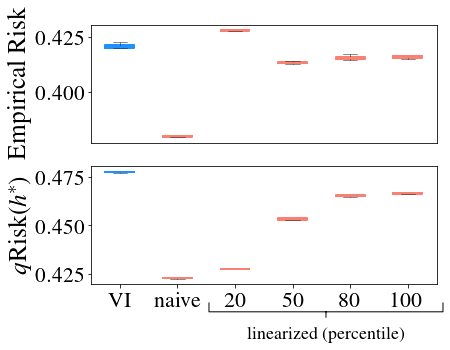

In [10]:
print("TEST DATA")
start_plotting(cmbright=False, font_size=17*1.5, 
               bottom=0.2, left=0.2, right=0.95, top=0.95)

ax1 = plt.subplot(211)
plot_boxes("test_erisk", ax1)
plt.xlim(0.5,6.5)
plt.grid(False); plt.title(""); plt.suptitle("");
plt.ylabel("Empirical Risk")
plt.xlabel("")
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off


ax2 = plt.subplot(212, sharex=ax1)
plot_boxes("test_qrisk", ax2)
plt.xticks([1,2,3,4,5,6,7], ["VI", "naive", "20", "50", "80", "100"], ha="center", fontsize=22)
ax2.annotate('linearized (percentile)', xy=(0.68, -0.22), xytext=(0.68, -0.5), xycoords='axes fraction', 
            fontsize=18, ha='center', va='bottom',
            bbox=dict(boxstyle='square', fc='white', lw=0),
            arrowprops=dict(arrowstyle='-[, widthB=6.5, lengthB=0.5', lw=1.0))
plt.grid(False); plt.title(""); plt.suptitle("");
#plt.yticks([0.39, 0.43], ["0.39", "0.43"])
plt.xlim(0.5,6.5)
plt.ylabel("$q$Risk($h^*$)")
plt.xlabel("");

plt.subplots_adjust(bottom=0.2, left=0.2, right=0.95, top=0.95) 
plt.savefig("mf_expsquared_test.pdf")
plt.show()

TRAINING DATA


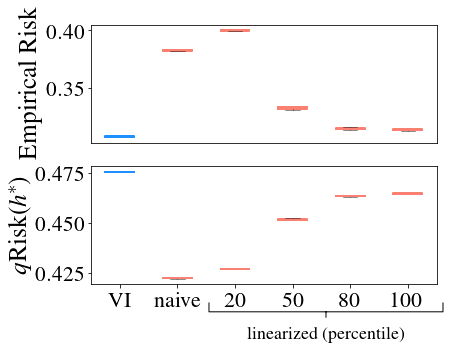

In [11]:
print("TRAINING DATA")
start_plotting(cmbright=False, font_size=17*1.5, 
               bottom=0.2, left=0.2, right=0.95, top=0.95)

ax1 = plt.subplot(211)
plot_boxes("train_erisk", ax1)
plt.xlim(0.5,6.5)
plt.grid(False); plt.title(""); plt.suptitle("");
plt.ylabel("Empirical Risk")
plt.xlabel("")
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off


ax2 = plt.subplot(212, sharex=ax1)
plot_boxes("train_qrisk", ax2)
plt.xticks([1,2,3,4,5,6,7], ["VI", "naive", "20", "50", "80", "100"], ha="center", fontsize=22)
ax2.annotate('linearized (percentile)', xy=(0.68, -0.22), xytext=(0.68, -0.5), xycoords='axes fraction', 
            fontsize=18, ha='center', va='bottom',
            bbox=dict(boxstyle='square', fc='white', lw=0),
            arrowprops=dict(arrowstyle='-[, widthB=6.5, lengthB=0.5', lw=1.0))
plt.grid(False); plt.title(""); plt.suptitle("");
#plt.yticks([0.39, 0.43], ["0.39", "0.43"])
plt.xlim(0.5,6.5)
plt.ylabel("$q$Risk($h^*$)")
plt.xlabel("");

plt.subplots_adjust(bottom=0.2, left=0.2, right=0.95, top=0.95) 
plt.savefig("mf_expsquared_training.pdf")
plt.show()

## Test Data Empirical Risk Reduction

In [12]:
dvi = d0[d0.logu=="vi"].sort_values(by="SEED")
dnaive = d0[d0.logu=="naive"].sort_values(by="SEED")
dlin20 = d0[(d0.logu=="linearized") & (d0.percentile==20.0)].sort_values(by="SEED")
dlin50 = d0[(d0.logu=="linearized") & (d0.percentile==50.0)].sort_values(by="SEED")
dlin80 = d0[(d0.logu=="linearized") & (d0.percentile==80.0)].sort_values(by="SEED")
dlin100 = d0[(d0.logu=="linearized") & (d0.percentile==100.0)].sort_values(by="SEED")

In [13]:
SHARED_SEEDS = set(dvi.SEED).intersection(dnaive.SEED).intersection(dlin100.SEED).intersection(dlin20.SEED).intersection(dlin50.SEED).intersection(dlin80.SEED)
print("SHARED_SEEDS=",SHARED_SEEDS)
dvi = dvi[dvi.SEED.isin(SHARED_SEEDS)].sort_values(by="SEED")
dnaive = dnaive[dnaive.SEED.isin(SHARED_SEEDS)].sort_values(by="SEED")
dlin20 = dlin20[dlin20.SEED.isin(SHARED_SEEDS)].sort_values(by="SEED")
dlin50 = dlin50[dlin50.SEED.isin(SHARED_SEEDS)].sort_values(by="SEED")
dlin80 = dlin80[dlin80.SEED.isin(SHARED_SEEDS)].sort_values(by="SEED")
dlin100 = dlin100[dlin100.SEED.isin(SHARED_SEEDS)].sort_values(by="SEED")

SHARED_SEEDS= {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10}


In [14]:
print("NUM SAMPLES USED TO PLOT BOXES:", len(dnaive),len(dlin20), len(dlin50), len(dlin80), len(dlin100))

NUM SAMPLES USED TO PLOT BOXES: 11 11 11 11 11


In [15]:
dnaive["test_erisk_improvement"] = -(np.array(dnaive["test_erisk"])-np.array(dvi["test_erisk"]))/np.array(dvi["test_erisk"]) * 100.0
dlin20["test_erisk_improvement"] = -(np.array(dlin20["test_erisk"])-np.array(dvi["test_erisk"]))/np.array(dvi["test_erisk"]) * 100.0
dlin50["test_erisk_improvement"] = -(np.array(dlin50["test_erisk"])-np.array(dvi["test_erisk"]))/np.array(dvi["test_erisk"]) * 100.0
dlin80["test_erisk_improvement"] = -(np.array(dlin80["test_erisk"])-np.array(dvi["test_erisk"]))/np.array(dvi["test_erisk"]) * 100.0
dlin100["test_erisk_improvement"] = -(np.array(dlin100["test_erisk"])-np.array(dvi["test_erisk"]))/np.array(dvi["test_erisk"]) * 100.0

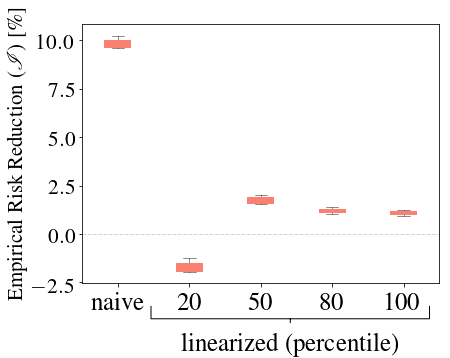

In [16]:
start_plotting(cmbright=False, font_size=17*1.5, left=0.175)

bp = plt.boxplot([dnaive["test_erisk_improvement"]], positions=[0], showfliers=False, widths=[0.35], patch_artist=True)
fix_colors2(bp, "salmon")   

bp = plt.boxplot([dlin20["test_erisk_improvement"]], positions=[1], showfliers=False, widths=[0.35], patch_artist=True)
fix_colors2(bp, "salmon")   


bp = plt.boxplot([dlin50["test_erisk_improvement"]], positions=[2], showfliers=False, widths=[0.35], patch_artist=True)
fix_colors2(bp, "salmon")   


bp = plt.boxplot([dlin80["test_erisk_improvement"]], positions=[3], showfliers=False, widths=[0.35], patch_artist=True)
fix_colors2(bp, "salmon")   


bp = plt.boxplot([dlin100["test_erisk_improvement"]], positions=[4], showfliers=False, widths=[0.35], patch_artist=True)
fix_colors2(bp, "salmon")   

    
plt.gca().annotate('linearized (percentile)', 
                   xy=(0.645, 0.115), xytext=(0.645, 0.005), xycoords='figure fraction', 
            fontsize=25, ha='center', va='bottom',
            bbox=dict(boxstyle='square', fc='white', lw=0),
            arrowprops=dict(arrowstyle='-[, widthB=5.57, lengthB=0.5', lw=1.0))        
    
plt.xticks([0,1,2,3,4], ["naive", "20", "50", "80", "100"], fontsize=25)      
plt.xlim(-0.5, 4.5)    
plt.axhline(0, color="lightgray", ls="--", lw=1)
#plt.ylim(0, 5)
plt.ylabel("Empirical Risk Reduction ($\mathcal{I}$) [\%]", fontsize=21)
plt.savefig("mf_expsquared_risk_improvement_test.pdf")
plt.show()